# Index

1. Preprocesing raw data <br>
    1.1.  Reading files<br>
    1.2. Resizing<br>
    1.3. Splitting data (50%-50% now)<br>
    1.4. Binarization<br>
    1.5. Normalization<br>
2. Model implementation: SVM<br>
    2.1. K-fold validation<br>

### Libraries

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA

from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

# 1. Preprocesing raw data

### 1.1 Reading data file

In [260]:
with open('mfeat-pix.txt') as f:
    raw_dataset = f.readlines()

In [261]:
for i in range(len(raw_dataset)):
    array = raw_dataset[i].split(' ')
    a = np.array('')
    # We do an array with the items
    for item in array:
        a = np.append(a, item)

    # We delete empty items
    a = a[a != ""]

    # We change it from string to float
    a = a.astype('float64')

    if i == 0:
        dataset = a
    else:
        dataset = np.vstack([dataset, a])

### 1.2 Resizing dataset

In [262]:
# Resizing to make 20 groups of 100 images, where each groups has 1 number
dataset = np.resize(dataset, (20, 24000))
dataset = np.array([np.resize(row, (100, 240))for row in dataset])
dataset.shape

(20, 100, 240)

### 1.3 Splitting data (50%-50% )

In [263]:
# Each X array has 100 images of one number (10 numbers = 1000 images)
X_train = dataset[::2]
X_test = dataset[1::2]
X_train.shape

(10, 100, 240)

In [264]:
# Creating array with the labels.
y_train=[0]
number = 0

for i in range(1,1000):
    if i%100 == 0 and i!=0:
        number+=1
        
    y_train = np.vstack([y_train, number])
    
y_test=y_train
y_train.shape

(1000, 1)

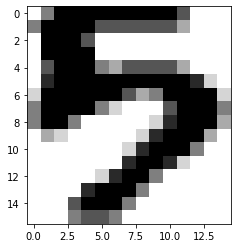

In [265]:
# Display of a number
display_number = X_train[5][10]
display_number = np.resize(display_number, (16, 15))

plt.imshow(display_number, cmap='binary')
plt.show()

In [266]:
# Creating array with the labels of the original dataset
dataset = np.resize(dataset, (2000, 240))
dataset_labels=[0]
number = 0

for i in range(1,2000):
    if i%200 == 0 and i!=0:
        number+=1
        
    dataset_labels = np.vstack([dataset_labels, number])
dataset.shape, dataset_labels.shape

((2000, 240), (2000, 1))

In [267]:
# Resizing
X_train = np.resize(X_train, (1000, 240))
X_test = np.resize(X_test, (1000, 240))

In [268]:
y_train =y_train.ravel()
y_test = y_test.ravel()

In [269]:
y_train.shape, X_train.shape

((1000,), (1000, 240))

### 1.4 Binarization

In [270]:
import cv2 as cv
retval, X_train = cv2.threshold(src = X_train, thresh =3, maxval=6, type=cv2.THRESH_BINARY)

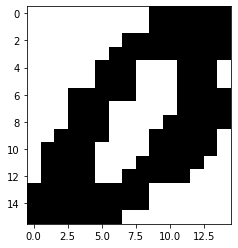

In [271]:
# Display a number to check
display_number = X_train[5]
display_number = np.resize(display_number, (16, 15))

plt.imshow(display_number, cmap='binary')
plt.show()

# 2. Model implementation: SVM 

#### With original data

In [272]:
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = 'rbf', random_state = 0)
classifier_SVM.fit(X_train, y_train)

SVC(random_state=0)

In [273]:
# We predict the labels of the test data
y_pred = classifier_SVM.predict(X_test)
y_pred.shape

(1000,)

In [274]:
y_test.shape

(1000,)

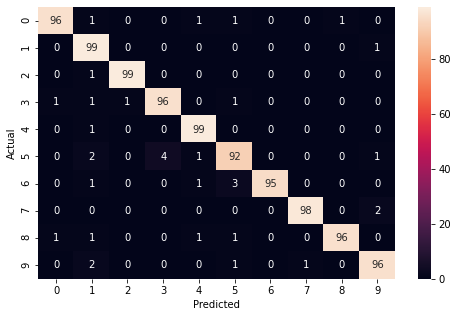

In [275]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [276]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.966

In [277]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

More metrics about the model.

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       100
         1.0       0.91      0.99      0.95       100
         2.0       0.99      0.99      0.99       100
         3.0       0.96      0.96      0.96       100
         4.0       0.96      0.99      0.98       100

   micro avg       0.96      0.98      0.97       500
   macro avg       0.96      0.98      0.97       500
weighted avg       0.96      0.98      0.97       500



#### Dimension reduction 

In [278]:
from sklearn.decomposition import KernelPCA
pcakernel = KernelPCA(n_components=100, kernel='rbf')
X_train_reduced = pcakernel.fit_transform(X_train)
X_test_reduced = pcakernel.transform(X_test)

In [279]:
from sklearn.svm import SVC
classifier_SVM = SVC(kernel = 'linear', random_state = 0)
classifier_SVM.fit(X_train_reduced, y_train)

SVC(kernel='linear', random_state=0)

In [280]:
# We predict the labels of the test data
y_pred = classifier_SVM.predict(X_test_reduced)
y_pred.shape

(1000,)

In [281]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.4

###  2.1 K-fold validation

In [282]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

def k_fold(folds):
    split_data = KFold(n_splits = folds, shuffle = True, random_state = np.random.RandomState(5))
    return split_data, folds

In [283]:
dt_k, dt_folds = k_fold(3)
dt_k_, dt_folds_ = k_fold(5)

input_data = dataset
label_data = dataset_labels.ravel()

result = cross_val_score(classifier_SVM , input_data, label_data, cv = dt_k)
print(f"Average accuracy from 3 folds: {result.mean()}\n")
result_ = cross_val_score(classifier_SVM , input_data, label_data, cv = dt_k_)
print(f"Average accuracy from 5 folds: {result_.mean()}")



Average accuracy from 3 folds: 0.9714984849917384

Average accuracy from 5 folds: 0.9734999999999999
